In [21]:
import sys
import random
import glob
sys.path.append("../")
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import os
import pandas as pd
from torch.optim import AdamW
from utils.custom_scheduler import CustomCosineAnnealingWarmRestarts
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from tqdm import trange
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

os.chdir("/home/dhai/coding/brain_project")
print("현재 작업 디렉토리:", os.getcwd())

# 상위 폴더로 이동한 경로로 파일 불러오기
df = pd.read_csv("./dataloader.csv")

# split 기준으로 나누기
train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "val"].reset_index(drop=True)
test_df  = df[df["split"] == "test"].reset_index(drop=True)

# 확인
print(f"✅ train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")

현재 작업 디렉토리: /home/dhai/coding/brain_project
✅ train: 505, val: 159, test: 195


In [22]:
class FMRIDataset(Dataset):
    def __init__(self, df, label_map):
        self.stories = []
        self.label_map = label_map

        for _, row in df.iterrows():
            fmri_path = row["run_path"]
            label = self.label_map[row["ground_truth"]]
            age = float(row["age"])  # adition infomation age

            text_dirs = [p.strip() for p in row["text_path"].split(",")]
            text_counts = [int(n) for n in str(row["text_frame"]).split(",")]
            fmri_files = sorted(
                glob.glob(os.path.join(fmri_path, "frame_*.pt")),
                key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split("_")[1])
            )
            assert len(fmri_files) == sum(text_counts), f"{fmri_path}: 파일 수 불일치"
            text_files_all = []
            for dir_path, count in zip(text_dirs, text_counts):
                # text_block_1.pt ~ text_block_count.pt
                text_files = sorted(
                    glob.glob(os.path.join(dir_path, "text_block_*.pt")),
                    key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split("_")[2])
                )
                # 만약 text_block_1.pt부터 시작이라면 text_files[:count]로 매칭
                text_files_all.extend(text_files[:count])

            # fmri와 text feature를 1:1로 매칭
            assert len(fmri_files) == len(text_files_all), f"{fmri_path}: 파일 수 불일치 fmri:{len(fmri_files)} text:{len(text_files_all)}"
            self.stories.append({
                "fmri_feats": fmri_files,
                "text_feats": text_files_all,
                "label": label,
                "age": age
            })

    def __len__(self):
        return len(self.stories)

    def __getitem__(self, idx):
        story = self.stories[idx]
        fmri_feats = torch.stack([torch.load(f).float() for f in story["fmri_feats"]])  # [num_frames, fmri_dim]
        text_feats = torch.stack([torch.load(f).float() for f in story["text_feats"]])  # [num_frames, text_dim]
        age_tensor = torch.tensor([story["age"]]).float()
        age_feats = age_tensor.expand(text_feats.size(0), 1)  # [num_frames, 1]
        text_feats = torch.cat([text_feats, age_feats], dim=1)  # [num_frames, text_dim+1]
        label = story["label"]
        return fmri_feats, text_feats, label

In [31]:
class SelfAttnPooling(nn.Module):
    def __init__(self, fmri_dim, hidden_dim):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(fmri_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x: [batch, num_frames, fmri_dim]
        attn_weights = self.attn(x).softmax(dim=1)  # [batch, num_frames, 1]
        pooled = (x * attn_weights).sum(dim=1)      # [batch, fmri_dim]
        return pooled
        
class TextToFMRI_Classifier(nn.Module):
    def __init__(self, text_dim, fmri_dim, hidden_dim, num_classes):
        super().__init__()
        self.reg_head = nn.Sequential(
            nn.Linear(text_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, fmri_dim)
        )
        self.attn_pool = SelfAttnPooling(fmri_dim, hidden_dim)
        self.class_head = nn.Sequential(
            nn.Linear(fmri_dim, hidden_dim),  # <-- 입력 차원 바뀜
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, text_feats):
        # text_feats: [batch, num_frames, text_dim]
        pred_fmri = self.reg_head(text_feats)              # [batch, num_frames, fmri_dim]
        pooled_fmri = pred_fmri.mean(dim=1)            # [batch, fmri_dim]
        pooled_text = text_feats.mean(dim=1)               # [batch, text_dim] (or other pooling)
        #concat = torch.cat([pooled_fmri, pooled_text], dim=-1)  # [batch, fmri_dim + text_dim]
        class_out = self.class_head(pooled_fmri)
        return pred_fmri, class_out

In [36]:
def train_epoch(dataloader, model, optimizer, scaler=None, writer=None, epoch=0, alpha=5.0):
    model.train()
    total_loss, total_reg_loss, total_cos_loss, total_cls_loss = 0, 0, 0, 0
    loss_reg = nn.MSELoss()
    #cosine_loss = nn.CosineEmbeddingLoss()
    loss_cls = nn.CrossEntropyLoss()
    for i, (fmri, text, label) in enumerate(dataloader):
        fmri, text, label = fmri.cuda(), text.cuda(), label.cuda()
        #fmri = fmri.squeeze(0)   # [num_frames, fmri_dim]
        #text = text.squeeze(0)   # [num_frames, text_dim]
        #label = label.squeeze(0) # scalar

        optimizer.zero_grad()
        if scaler:
            with torch.cuda.amp.autocast():
                pred_fmri, pred_label = model(text)  # [1, num_frames, fmri_dim]
                pooled_fmri = pred_fmri.mean(dim=1)
                pooled_text = text.mean(dim=1)

                class_out = model.class_head(pooled_fmri)

                reg_loss = loss_reg(pred_fmri, fmri)
                cls_loss = loss_cls(class_out, label)
                loss = reg_loss + alpha * cls_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            pred_fmri, pred_label = model(text)
            reg_loss = loss_reg(pred_fmri, fmri)
            #cos_target = torch.ones(fmri.shape[0]*fmri.shape[1]).cuda()
            #cos_loss = cosine_loss(pred_fmri.reshape(-1, fmri.shape[-1]), fmri.reshape(-1, fmri.shape[-1]), cos_target)
            cls_loss = loss_cls(pred_label, label)
            loss = reg_loss + cls_loss
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        total_reg_loss += reg_loss.item()
        #total_cos_loss += cos_loss.item()
        total_cls_loss += cls_loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_reg_loss = total_reg_loss / len(dataloader)
    #avg_cos_loss = total_cos_loss / len(dataloader)
    avg_cls_loss = total_cls_loss / len(dataloader)

    if writer:
        writer.add_scalar('LearningRate/Train_lr', optimizer.param_groups[0]['lr'], epoch)     
        writer.add_scalar('Train/TotalLoss', avg_loss, epoch)
        writer.add_scalar('Train/RegLoss', avg_reg_loss, epoch)
        #writer.add_scalar('Train/CosLoss', avg_cos_loss, epoch)
        writer.add_scalar('Train/ClsLoss', avg_cls_loss, epoch)
    return avg_loss

def validate_epoch_pretrain(dataloader, model, epoch, writer=None):
    model.eval()
    total_loss, total_reg_loss, total_cos_loss, total_cls_loss = 0, 0, 0, 0
    loss_reg = nn.MSELoss()
    #cosine_loss = nn.CosineEmbeddingLoss()
    loss_cls = nn.CrossEntropyLoss()
    with torch.no_grad():
        for fmri, text, label in dataloader:
            fmri, text, label = fmri.cuda(), text.cuda(), label.cuda()
            #fmri = fmri.squeeze(0)
            #text = text.squeeze(0)
            #label = label.squeeze(0)

            pred_fmri, pred_label = model(text)
            reg_loss = loss_reg(pred_fmri, fmri)
            #cos_target = torch.ones(fmri.shape[0]*fmri.shape[1]).cuda()
            #cos_loss = cosine_loss(pred_fmri.reshape(-1, fmri.shape[-1]), fmri.reshape(-1, fmri.shape[-1]), cos_target)
            cls_loss = loss_cls(pred_label, label)
            loss = reg_loss + cls_loss

            total_loss += loss.item()
            total_reg_loss += reg_loss.item()
            #total_cos_loss += cos_loss.item()
            total_cls_loss += cls_loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_reg_loss = total_reg_loss / len(dataloader)
    #avg_cos_loss = total_cos_loss / len(dataloader)
    avg_cls_loss = total_cls_loss / len(dataloader)
    if writer:
        writer.add_scalar('Val/TotalLoss', avg_loss, epoch)
        writer.add_scalar('Val/RegLoss', avg_reg_loss, epoch)
        #writer.add_scalar('Val/CosLoss', avg_cos_loss, epoch)
        writer.add_scalar('Val/ClsLoss', avg_cls_loss, epoch)
    return avg_loss, avg_reg_loss, avg_cls_loss


In [37]:
label_map = {"all": 0, "15": 1, "19": 2}
batch_sizes = 1
train_dataset = FMRIDataset(train_df, label_map)
val_dataset   = FMRIDataset(val_df, label_map)

train_loader = DataLoader(train_dataset, batch_size=batch_sizes, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_sizes)

In [47]:
model = TextToFMRI_Classifier(text_dim=769, fmri_dim=288, hidden_dim=512, num_classes=3).cuda()
optimizer = AdamW(model.parameters(), lr=0.00002, weight_decay=0.05, betas=(0.9, 0.999))
scheduler = CustomCosineAnnealingWarmRestarts(optimizer=optimizer, T_0=50, T_mult=2, eta_min=0, eta_max=0.00002, decay_factor=0.9, start_epoch=0)
epochs = 50
scaler = GradScaler()
writer = SummaryWriter(log_dir="./tensorboard/experiment_9")
best_val_loss = float('inf')

for epoch in trange(epochs):
    train_loss = train_epoch(train_loader, model, optimizer, scaler, writer, epoch)
    val_loss, reg_loss, cls_loss = validate_epoch_pretrain(val_loader, model, epoch, writer)
    scheduler.step(epoch)
    print(f"[{epoch+1}/{epochs}] TrainLoss: {train_loss:.4f}  ValLoss: {val_loss:.4f} val_regloss: {reg_loss:.4f} val_clsloss: {cls_loss:.4f}")

    # Best 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "./experiments/experiment_9_best_model.pth")
        print("save best model")

writer.close()

/tmp/ipykernel_18137/1247874104.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


[DEBUG step] epoch=0, effective_epoch=0, T_cur=0, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=0, T_cur=0, current_cycle=0, _last_lr=[2e-05]


/tmp/ipykernel_18137/1524043791.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
  2%|▉                                           | 1/50 [00:03<03:04,  3.77s/it]

[DEBUG step] epoch=0, effective_epoch=0, T_cur=0, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=0, T_cur=0, current_cycle=0, _last_lr=[2e-05]
[1/50] TrainLoss: 5.6791  ValLoss: 1.9138 val_regloss: 0.4929 val_clsloss: 1.4209
save best model


  4%|█▊                                          | 2/50 [00:07<02:59,  3.74s/it]

[DEBUG step] epoch=1, effective_epoch=1, T_cur=1, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=1, T_cur=1, current_cycle=0, _last_lr=[1.9980267284282718e-05]
[2/50] TrainLoss: 4.3203  ValLoss: 1.6591 val_regloss: 0.4080 val_clsloss: 1.2510
save best model


  6%|██▋                                         | 3/50 [00:11<02:55,  3.73s/it]

[DEBUG step] epoch=2, effective_epoch=2, T_cur=2, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=2, T_cur=2, current_cycle=0, _last_lr=[1.9921147013144782e-05]
[3/50] TrainLoss: 2.1685  ValLoss: 1.6448 val_regloss: 0.3500 val_clsloss: 1.2949
save best model


  8%|███▌                                        | 4/50 [00:14<02:51,  3.73s/it]

[DEBUG step] epoch=3, effective_epoch=3, T_cur=3, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=3, T_cur=3, current_cycle=0, _last_lr=[1.982287250728689e-05]
[4/50] TrainLoss: 0.9686  ValLoss: 1.9993 val_regloss: 0.3110 val_clsloss: 1.6883


 10%|████▍                                       | 5/50 [00:18<02:47,  3.71s/it]

[DEBUG step] epoch=4, effective_epoch=4, T_cur=4, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=4, T_cur=4, current_cycle=0, _last_lr=[1.9685831611286312e-05]
[5/50] TrainLoss: 0.5291  ValLoss: 1.9002 val_regloss: 0.2769 val_clsloss: 1.6233


 12%|█████▎                                      | 6/50 [00:22<02:44,  3.74s/it]

[DEBUG step] epoch=5, effective_epoch=5, T_cur=5, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=5, T_cur=5, current_cycle=0, _last_lr=[1.9510565162951538e-05]
[6/50] TrainLoss: 0.3656  ValLoss: 1.9182 val_regloss: 0.2517 val_clsloss: 1.6666


 14%|██████▏                                     | 7/50 [00:26<02:40,  3.74s/it]

[DEBUG step] epoch=6, effective_epoch=6, T_cur=6, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=6, T_cur=6, current_cycle=0, _last_lr=[1.9297764858882516e-05]
[7/50] TrainLoss: 0.2888  ValLoss: 1.9276 val_regloss: 0.2364 val_clsloss: 1.6912


 16%|███████                                     | 8/50 [00:29<02:35,  3.71s/it]

[DEBUG step] epoch=7, effective_epoch=7, T_cur=7, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=7, T_cur=7, current_cycle=0, _last_lr=[1.9048270524660197e-05]
[8/50] TrainLoss: 0.2444  ValLoss: 1.7978 val_regloss: 0.2253 val_clsloss: 1.5725


 18%|███████▉                                    | 9/50 [00:33<02:31,  3.69s/it]

[DEBUG step] epoch=8, effective_epoch=8, T_cur=8, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=8, T_cur=8, current_cycle=0, _last_lr=[1.8763066800438638e-05]
[9/50] TrainLoss: 0.2172  ValLoss: 1.8793 val_regloss: 0.2223 val_clsloss: 1.6570


 20%|████████▌                                  | 10/50 [00:37<02:27,  3.68s/it]

[DEBUG step] epoch=9, effective_epoch=9, T_cur=9, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=9, T_cur=9, current_cycle=0, _last_lr=[1.8443279255020153e-05]
[10/50] TrainLoss: 0.1993  ValLoss: 1.7820 val_regloss: 0.2215 val_clsloss: 1.5605


 22%|█████████▍                                 | 11/50 [00:40<02:23,  3.67s/it]

[DEBUG step] epoch=10, effective_epoch=10, T_cur=10, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=10, T_cur=10, current_cycle=0, _last_lr=[1.8090169943749477e-05]
[11/50] TrainLoss: 0.1865  ValLoss: 1.7804 val_regloss: 0.2174 val_clsloss: 1.5630


 24%|██████████▎                                | 12/50 [00:44<02:19,  3.67s/it]

[DEBUG step] epoch=11, effective_epoch=11, T_cur=11, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=11, T_cur=11, current_cycle=0, _last_lr=[1.7705132427757895e-05]
[12/50] TrainLoss: 0.1761  ValLoss: 1.7705 val_regloss: 0.2184 val_clsloss: 1.5521


 26%|███████████▏                               | 13/50 [00:48<02:15,  3.66s/it]

[DEBUG step] epoch=12, effective_epoch=12, T_cur=12, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=12, T_cur=12, current_cycle=0, _last_lr=[1.7289686274214116e-05]
[13/50] TrainLoss: 0.1674  ValLoss: 1.7012 val_regloss: 0.2182 val_clsloss: 1.4830


 28%|████████████                               | 14/50 [00:51<02:11,  3.66s/it]

[DEBUG step] epoch=13, effective_epoch=13, T_cur=13, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=13, T_cur=13, current_cycle=0, _last_lr=[1.684547105928689e-05]
[14/50] TrainLoss: 0.1594  ValLoss: 1.6885 val_regloss: 0.2146 val_clsloss: 1.4738


 30%|████████████▉                              | 15/50 [00:55<02:08,  3.66s/it]

[DEBUG step] epoch=14, effective_epoch=14, T_cur=14, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=14, T_cur=14, current_cycle=0, _last_lr=[1.63742398974869e-05]
[15/50] TrainLoss: 0.1522  ValLoss: 1.6911 val_regloss: 0.2163 val_clsloss: 1.4748


 32%|█████████████▊                             | 16/50 [00:59<02:04,  3.67s/it]

[DEBUG step] epoch=15, effective_epoch=15, T_cur=15, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=15, T_cur=15, current_cycle=0, _last_lr=[1.5877852522924736e-05]
[16/50] TrainLoss: 0.1452  ValLoss: 1.6673 val_regloss: 0.2170 val_clsloss: 1.4503


 34%|██████████████▌                            | 17/50 [01:02<02:01,  3.67s/it]

[DEBUG step] epoch=16, effective_epoch=16, T_cur=16, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=16, T_cur=16, current_cycle=0, _last_lr=[1.5358267949789968e-05]
[17/50] TrainLoss: 0.1388  ValLoss: 1.6947 val_regloss: 0.2105 val_clsloss: 1.4843


 36%|███████████████▍                           | 18/50 [01:06<01:57,  3.66s/it]

[DEBUG step] epoch=17, effective_epoch=17, T_cur=17, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=17, T_cur=17, current_cycle=0, _last_lr=[1.4817536741017153e-05]
[18/50] TrainLoss: 0.1324  ValLoss: 1.6908 val_regloss: 0.2150 val_clsloss: 1.4758


 38%|████████████████▎                          | 19/50 [01:10<01:54,  3.69s/it]

[DEBUG step] epoch=18, effective_epoch=18, T_cur=18, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=18, T_cur=18, current_cycle=0, _last_lr=[1.4257792915650728e-05]
[19/50] TrainLoss: 0.1266  ValLoss: 1.6740 val_regloss: 0.2074 val_clsloss: 1.4665


 40%|█████████████████▏                         | 20/50 [01:13<01:51,  3.70s/it]

[DEBUG step] epoch=19, effective_epoch=19, T_cur=19, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=19, T_cur=19, current_cycle=0, _last_lr=[1.3681245526846782e-05]
[20/50] TrainLoss: 0.1205  ValLoss: 1.6738 val_regloss: 0.2044 val_clsloss: 1.4695


 42%|██████████████████                         | 21/50 [01:17<01:46,  3.69s/it]

[DEBUG step] epoch=20, effective_epoch=20, T_cur=20, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=20, T_cur=20, current_cycle=0, _last_lr=[1.3090169943749475e-05]
[21/50] TrainLoss: 0.1148  ValLoss: 1.6704 val_regloss: 0.1974 val_clsloss: 1.4730


 44%|██████████████████▉                        | 22/50 [01:21<01:44,  3.72s/it]

[DEBUG step] epoch=21, effective_epoch=21, T_cur=21, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=21, T_cur=21, current_cycle=0, _last_lr=[1.2486898871648547e-05]
[22/50] TrainLoss: 0.1096  ValLoss: 1.6220 val_regloss: 0.1970 val_clsloss: 1.4250
save best model


 46%|███████████████████▊                       | 23/50 [01:25<01:40,  3.71s/it]

[DEBUG step] epoch=22, effective_epoch=22, T_cur=22, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=22, T_cur=22, current_cycle=0, _last_lr=[1.187381314585725e-05]
[23/50] TrainLoss: 0.1050  ValLoss: 1.6437 val_regloss: 0.1975 val_clsloss: 1.4462


 48%|████████████████████▋                      | 24/50 [01:28<01:36,  3.72s/it]

[DEBUG step] epoch=23, effective_epoch=23, T_cur=23, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=23, T_cur=23, current_cycle=0, _last_lr=[1.1253332335643045e-05]
[24/50] TrainLoss: 0.1009  ValLoss: 1.5827 val_regloss: 0.1921 val_clsloss: 1.3906
save best model


 50%|█████████████████████▌                     | 25/50 [01:32<01:32,  3.71s/it]

[DEBUG step] epoch=24, effective_epoch=24, T_cur=24, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=24, T_cur=24, current_cycle=0, _last_lr=[1.0627905195293135e-05]
[25/50] TrainLoss: 0.0974  ValLoss: 1.6320 val_regloss: 0.1873 val_clsloss: 1.4447


 52%|██████████████████████▎                    | 26/50 [01:36<01:28,  3.70s/it]

[DEBUG step] epoch=25, effective_epoch=25, T_cur=25, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=25, T_cur=25, current_cycle=0, _last_lr=[1e-05]
[26/50] TrainLoss: 0.0944  ValLoss: 1.5854 val_regloss: 0.1917 val_clsloss: 1.3937


 54%|███████████████████████▏                   | 27/50 [01:39<01:24,  3.69s/it]

[DEBUG step] epoch=26, effective_epoch=26, T_cur=26, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=26, T_cur=26, current_cycle=0, _last_lr=[9.372094804706867e-06]
[27/50] TrainLoss: 0.0919  ValLoss: 1.6083 val_regloss: 0.1889 val_clsloss: 1.4195


 56%|████████████████████████                   | 28/50 [01:43<01:20,  3.68s/it]

[DEBUG step] epoch=27, effective_epoch=27, T_cur=27, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=27, T_cur=27, current_cycle=0, _last_lr=[8.74666766435696e-06]
[28/50] TrainLoss: 0.0898  ValLoss: 1.6168 val_regloss: 0.1869 val_clsloss: 1.4298


 58%|████████████████████████▉                  | 29/50 [01:47<01:17,  3.68s/it]

[DEBUG step] epoch=28, effective_epoch=28, T_cur=28, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=28, T_cur=28, current_cycle=0, _last_lr=[8.126186854142754e-06]
[29/50] TrainLoss: 0.0879  ValLoss: 1.6122 val_regloss: 0.1849 val_clsloss: 1.4273


 60%|█████████████████████████▊                 | 30/50 [01:50<01:13,  3.69s/it]

[DEBUG step] epoch=29, effective_epoch=29, T_cur=29, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=29, T_cur=29, current_cycle=0, _last_lr=[7.513101128351452e-06]
[30/50] TrainLoss: 0.0864  ValLoss: 1.5590 val_regloss: 0.1853 val_clsloss: 1.3737
save best model


 62%|██████████████████████████▋                | 31/50 [01:54<01:10,  3.71s/it]

[DEBUG step] epoch=30, effective_epoch=30, T_cur=30, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=30, T_cur=30, current_cycle=0, _last_lr=[6.9098300562505296e-06]
[31/50] TrainLoss: 0.0851  ValLoss: 1.5572 val_regloss: 0.1831 val_clsloss: 1.3741
save best model


 64%|███████████████████████████▌               | 32/50 [01:58<01:07,  3.72s/it]

[DEBUG step] epoch=31, effective_epoch=31, T_cur=31, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=31, T_cur=31, current_cycle=0, _last_lr=[6.318754473153224e-06]
[32/50] TrainLoss: 0.0838  ValLoss: 1.5897 val_regloss: 0.1819 val_clsloss: 1.4078


 66%|████████████████████████████▍              | 33/50 [02:02<01:03,  3.72s/it]

[DEBUG step] epoch=32, effective_epoch=32, T_cur=32, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=32, T_cur=32, current_cycle=0, _last_lr=[5.742207084349274e-06]
[33/50] TrainLoss: 0.0829  ValLoss: 1.5668 val_regloss: 0.1817 val_clsloss: 1.3851


 68%|█████████████████████████████▏             | 34/50 [02:05<00:59,  3.71s/it]

[DEBUG step] epoch=33, effective_epoch=33, T_cur=33, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=33, T_cur=33, current_cycle=0, _last_lr=[5.1824632589828465e-06]
[34/50] TrainLoss: 0.0820  ValLoss: 1.6431 val_regloss: 0.1815 val_clsloss: 1.4616


 70%|██████████████████████████████             | 35/50 [02:09<00:56,  3.74s/it]

[DEBUG step] epoch=34, effective_epoch=34, T_cur=34, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=34, T_cur=34, current_cycle=0, _last_lr=[4.641732050210032e-06]
[35/50] TrainLoss: 0.0812  ValLoss: 1.6045 val_regloss: 0.1806 val_clsloss: 1.4239


 72%|██████████████████████████████▉            | 36/50 [02:13<00:52,  3.77s/it]

[DEBUG step] epoch=35, effective_epoch=35, T_cur=35, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=35, T_cur=35, current_cycle=0, _last_lr=[4.12214747707527e-06]
[36/50] TrainLoss: 0.0806  ValLoss: 1.6435 val_regloss: 0.1799 val_clsloss: 1.4636


 74%|███████████████████████████████▊           | 37/50 [02:17<00:49,  3.78s/it]

[DEBUG step] epoch=36, effective_epoch=36, T_cur=36, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=36, T_cur=36, current_cycle=0, _last_lr=[3.625760102513103e-06]
[37/50] TrainLoss: 0.0800  ValLoss: 1.5639 val_regloss: 0.1813 val_clsloss: 1.3826


 76%|████████████████████████████████▋          | 38/50 [02:21<00:47,  3.92s/it]

[DEBUG step] epoch=37, effective_epoch=37, T_cur=37, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=37, T_cur=37, current_cycle=0, _last_lr=[3.1545289407131128e-06]
[38/50] TrainLoss: 0.0795  ValLoss: 1.6141 val_regloss: 0.1821 val_clsloss: 1.4320


 78%|█████████████████████████████████▌         | 39/50 [02:25<00:42,  3.87s/it]

[DEBUG step] epoch=38, effective_epoch=38, T_cur=38, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=38, T_cur=38, current_cycle=0, _last_lr=[2.7103137257858867e-06]
[39/50] TrainLoss: 0.0791  ValLoss: 1.6111 val_regloss: 0.1813 val_clsloss: 1.4299


 80%|██████████████████████████████████▍        | 40/50 [02:28<00:38,  3.81s/it]

[DEBUG step] epoch=39, effective_epoch=39, T_cur=39, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=39, T_cur=39, current_cycle=0, _last_lr=[2.2948675722421086e-06]
[40/50] TrainLoss: 0.0787  ValLoss: 1.6004 val_regloss: 0.1801 val_clsloss: 1.4203


 82%|███████████████████████████████████▎       | 41/50 [02:32<00:33,  3.76s/it]

[DEBUG step] epoch=40, effective_epoch=40, T_cur=40, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=40, T_cur=40, current_cycle=0, _last_lr=[1.9098300562505266e-06]
[41/50] TrainLoss: 0.0784  ValLoss: 1.6329 val_regloss: 0.1800 val_clsloss: 1.4529


 84%|████████████████████████████████████       | 42/50 [02:36<00:29,  3.73s/it]

[DEBUG step] epoch=41, effective_epoch=41, T_cur=41, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=41, T_cur=41, current_cycle=0, _last_lr=[1.5567207449798517e-06]
[42/50] TrainLoss: 0.0782  ValLoss: 1.6342 val_regloss: 0.1802 val_clsloss: 1.4540


 86%|████████████████████████████████████▉      | 43/50 [02:39<00:25,  3.71s/it]

[DEBUG step] epoch=42, effective_epoch=42, T_cur=42, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=42, T_cur=42, current_cycle=0, _last_lr=[1.2369331995613643e-06]
[43/50] TrainLoss: 0.0780  ValLoss: 1.6297 val_regloss: 0.1801 val_clsloss: 1.4496


 88%|█████████████████████████████████████▊     | 44/50 [02:43<00:22,  3.70s/it]

[DEBUG step] epoch=43, effective_epoch=43, T_cur=43, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=43, T_cur=43, current_cycle=0, _last_lr=[9.517294753398066e-07]
[44/50] TrainLoss: 0.0778  ValLoss: 1.6243 val_regloss: 0.1801 val_clsloss: 1.4442


 90%|██████████████████████████████████████▋    | 45/50 [02:47<00:18,  3.70s/it]

[DEBUG step] epoch=44, effective_epoch=44, T_cur=44, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=44, T_cur=44, current_cycle=0, _last_lr=[7.022351411174866e-07]
[45/50] TrainLoss: 0.0777  ValLoss: 1.6235 val_regloss: 0.1802 val_clsloss: 1.4433


 92%|███████████████████████████████████████▌   | 46/50 [02:50<00:14,  3.69s/it]

[DEBUG step] epoch=45, effective_epoch=45, T_cur=45, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=45, T_cur=45, current_cycle=0, _last_lr=[4.894348370484648e-07]
[46/50] TrainLoss: 0.0776  ValLoss: 1.6263 val_regloss: 0.1802 val_clsloss: 1.4461


 94%|████████████████████████████████████████▍  | 47/50 [02:54<00:11,  3.71s/it]

[DEBUG step] epoch=46, effective_epoch=46, T_cur=46, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=46, T_cur=46, current_cycle=0, _last_lr=[3.1416838871369036e-07]
[47/50] TrainLoss: 0.0775  ValLoss: 1.6343 val_regloss: 0.1801 val_clsloss: 1.4542


 96%|█████████████████████████████████████████▎ | 48/50 [02:58<00:07,  3.71s/it]

[DEBUG step] epoch=47, effective_epoch=47, T_cur=47, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=47, T_cur=47, current_cycle=0, _last_lr=[1.771274927131128e-07]
[48/50] TrainLoss: 0.0774  ValLoss: 1.6306 val_regloss: 0.1801 val_clsloss: 1.4504


 98%|██████████████████████████████████████████▏| 49/50 [03:01<00:03,  3.69s/it]

[DEBUG step] epoch=48, effective_epoch=48, T_cur=48, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=48, T_cur=48, current_cycle=0, _last_lr=[7.885298685522235e-08]
[49/50] TrainLoss: 0.0774  ValLoss: 1.6305 val_regloss: 0.1801 val_clsloss: 1.4503


100%|███████████████████████████████████████████| 50/50 [03:05<00:00,  3.71s/it]

[DEBUG step] epoch=49, effective_epoch=49, T_cur=49, T_total=50, current_cycle=0, eta_max=2e-05
[DEBUG step] After step: last_epoch=49, T_cur=49, current_cycle=0, _last_lr=[1.973271571728441e-08]
[50/50] TrainLoss: 0.0774  ValLoss: 1.6302 val_regloss: 0.1801 val_clsloss: 1.4501


In [ ]:
label_map = {"all": 0, "15": 1, "19": 2}
test_dataset = FMRIDataset(test_df, label_map)

test_loader   = DataLoader(test_dataset, batch_size=1)

# 모델 정의 (TextMultiTaskNet이랑 동일해야 함)
model = TextToFMRI_Classifier(text_dim = 769, fmri_dim = 288, hidden_dim = 512, num_classes = 3).cuda()
model.load_state_dict(torch.load("./experiments/experiment_5_best_model.pth"))
model.eval()

# Loss 함수
mse_loss = nn.MSELoss()
cosine_loss = nn.CosineEmbeddingLoss()
ce_loss = nn.CrossEntropyLoss()

# Test loop
total, correct = 0, 0
total_mse, total_cos = 0, 0
total_ce = 0

with torch.no_grad():
    for fmri, text, label in test_loader:
        fmri, text, label = fmri.cuda(), text.cuda(), label.cuda()
        pred_fmri, pred_label = model(text)
        
        # Regression(MSE)
        mse = mse_loss(pred_fmri.squeeze(0), fmri.squeeze(0))
        total_mse += mse.item()
        
        # Cosine
        cos_target = torch.ones(fmri.squeeze(0).shape[0]).cuda()
        cos = cosine_loss(pred_fmri.squeeze(0), fmri.squeeze(0), cos_target)
        total_cos += cos.item()
        
        # Classification
        ce = ce_loss(pred_label, label)
        total_ce += ce.item()
        preds = pred_label.argmax(dim=1)
        correct += (preds == label).sum().item()
        total += label.size(0)

avg_mse = total_mse / len(test_loader)
avg_cos = total_cos / len(test_loader)
avg_ce = total_ce / len(test_loader)
acc = correct / total

print(f"Test Accuracy: {acc:.4f}")
print(f"Test MSE Loss: {avg_mse:.4f}")
print(f"Test Cosine Loss: {avg_cos:.4f}")
print(f"Test CrossEntropy Loss: {avg_ce:.4f}")

Test Accuracy: 1.0000
Test MSE Loss: 0.1030
Test CrossEntropy Loss: 0.4524

Confusion Matrix:
[[ 46   0   0]
 [  0 103   0]
 [  0   0  46]]

Classification Report:
              precision    recall  f1-score   support

         all       1.00      1.00      1.00        46
          15       1.00      1.00      1.00       103
          19       1.00      1.00      1.00        46

    accuracy                           1.00       195
   macro avg       1.00      1.00      1.00       195
weighted avg       1.00      1.00      1.00       195



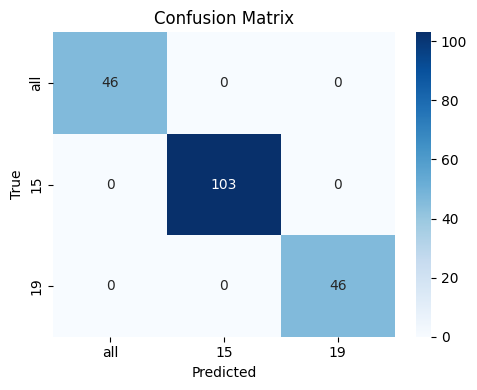

In [49]:
from sklearn.metrics import confusion_matrix, classification_report

label_map = {"all": 0, "15": 1, "19": 2}
inv_label_map = {v: k for k, v in label_map.items()}  # 숫자를 다시 텍스트로 바꿀 때

test_dataset = FMRIDataset(test_df, label_map)
test_loader  = DataLoader(test_dataset, batch_size=1)

model = TextToFMRI_Classifier(text_dim=769, fmri_dim=288, hidden_dim=512, num_classes=3).cuda()
model.load_state_dict(torch.load("./experiments/experiment_9_best_model.pth"))
model.eval()

mse_loss = nn.MSELoss()
#cosine_loss = nn.CosineEmbeddingLoss()
ce_loss = nn.CrossEntropyLoss()

total, correct = 0, 0
total_mse, total_cos, total_ce = 0, 0, 0

all_labels = []
all_preds = []

with torch.no_grad():
    for fmri, text, label in test_loader:
        fmri, text, label = fmri.cuda(), text.cuda(), label.cuda()
        pred_fmri, pred_label = model(text)

        # Regression(MSE)
        mse = mse_loss(pred_fmri.squeeze(0), fmri.squeeze(0))
        total_mse += mse.item()

        # Cosine
        #cos_target = torch.ones(fmri.squeeze(0).shape[0]).cuda()
        #cos = cosine_loss(pred_fmri.squeeze(0), fmri.squeeze(0), cos_target)
        #total_cos += cos.item()

        # Classification
        ce = ce_loss(pred_label, label)
        total_ce += ce.item()
        preds = pred_label.argmax(dim=1)
        correct += (preds == label).sum().item()
        total += label.size(0)

        # 리스트에 저장 (confusion matrix, report용)
        all_preds.append(preds.item())
        all_labels.append(label.item())

avg_mse = total_mse / len(test_loader)
#avg_cos = total_cos / len(test_loader)
avg_ce = total_ce / len(test_loader)
acc = correct / total

print(f"Test Accuracy: {acc:.4f}")
print(f"Test MSE Loss: {avg_mse:.4f}")
#print(f"Test Cosine Loss: {avg_cos:.4f}")
print(f"Test CrossEntropy Loss: {avg_ce:.4f}")

# Confusion Matrix & Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["all", "15", "19"]))

# Confusion Matrix 생성
cm = confusion_matrix(all_labels, all_preds)
labels = ["all", "15", "19"]

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()